<h1> Time series prediction, end-to-end </h1>

This notebook illustrates several models to find the next value of a time-series:
<ol>
<li> Linear
<li> DNN
<li> CNN 
<li> RNN
</ol>

In [1]:
# change these to try this notebook out
BUCKET = 'qwiklabs-gcp-15a5fa72dfa7c9e2'
PROJECT = 'qwiklabs-gcp-15a5fa72dfa7c9e2'
REGION = 'us-central1'
SEQ_LEN = 50

In [2]:
import os
os.environ['BUCKET'] = BUCKET
os.environ['PROJECT'] = PROJECT
os.environ['REGION'] = REGION
os.environ['SEQ_LEN'] = str(SEQ_LEN)
os.environ['TFVERSION'] = '1.8'

<h3> Simulate some time-series data </h3>

Essentially a set of sinusoids with random amplitudes and frequencies.

In [3]:
import tensorflow as tf
print(tf.__version__)

/usr/local/envs/py3env/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.8.0


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


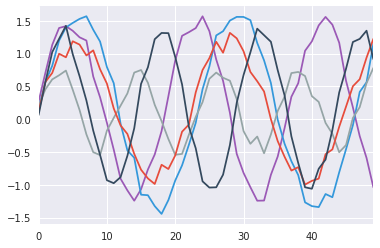

In [4]:
import numpy as np
import seaborn as sns

def create_time_series():
  freq = (np.random.random()*0.5) + 0.1  # 0.1 to 0.6
  ampl = np.random.random() + 0.5  # 0.5 to 1.5
  noise = [np.random.random()*0.3 for i in range(SEQ_LEN)] # -0.3 to +0.3 uniformly distributed
  x = np.sin(np.arange(0,SEQ_LEN) * freq) * ampl + noise
  return x

flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
for i in range(0, 5):
  sns.tsplot( create_time_series(), color=flatui[i%len(flatui)] );  # 5 series

In [5]:
def to_csv(filename, N):
  with open(filename, 'w') as ofp:
    for lineno in range(0, N):
      seq = create_time_series()
      line = ",".join(map(str, seq))
      ofp.write(line + '\n')

import os
try:
  os.makedirs('data/sines/')
except OSError:
  pass
to_csv('data/sines/train-1.csv', 1000)  # 1000 sequences
to_csv('data/sines/valid-1.csv', 250)

In [6]:
!head -5 data/sines/*-1.csv

==> data/sines/train-1.csv <==
0.16224786801544255,0.3493354681276124,0.726468013480716,1.0307154163531835,1.1562200496410922,1.1320058934602,1.2245233901660975,0.9376749605085758,0.5687854475333577,0.4529255465163789,0.16629574402094996,-0.2649757098071173,-0.5235576628952902,-0.6404477203716707,-0.8844795267773441,-0.8683560109970413,-0.6344866249809549,-0.588837214633745,-0.41625012799144034,-0.2719904244675292,0.21793992667567227,0.5329236060800908,0.6912366692311046,0.8415146426159718,1.012882297753027,1.156327117907016,1.120443115283264,0.8336857008590794,0.8274251523832418,0.4439024095463554,0.2519384746818758,-0.051001502655603825,-0.3029178634665909,-0.6254830230512862,-0.6845292452284777,-0.914961855287957,-0.7898778545913595,-0.6435300688876513,-0.476600851399,-0.2283157032200719,0.21642282383615696,0.35099702338684685,0.8833423863325526,1.0531899372389268,1.1121938890834127,0.985502110924052,1.1013589242658335,0.9266800833797872,0.5761090273482425,0.4755695971931053
0.14883

<h3> Train model locally </h3>

Make sure the code works as intended.

The `model.py` and `task.py` containing the model code is in <a href="sinemodel">sinemodel/</a>

**Complete the TODOs in `model.py` before proceeding!**

Once you've completed the TODOs, set `--model` below to the appropriate model (linear,dnn,cnn,rnn,rnn2 or rnnN) and run it locally for a few steps to test the code.

In [7]:
%%bash
DATADIR=$(pwd)/data/sines
OUTDIR=$(pwd)/trained/sines
rm -rf $OUTDIR
gcloud ml-engine local train \
   --module-name=sinemodel.task \
   --package-path=${PWD}/sinemodel \
   -- \
   --train_data_path="${DATADIR}/train-1.csv" \
   --eval_data_path="${DATADIR}/valid-1.csv"  \
   --output_dir=${OUTDIR} \
   --model=cnn --train_steps=10 --sequence_length=$SEQ_LEN

/usr/local/envs/py3env/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
INFO:tensorflow:TF_CONFIG environment variable: {'environment': 'cloud', 'cluster': {}, 'task': {}, 'job': {'job_name': 'sinemodel.task', 'args': ['--train_data_path=/content/datalab/notebooks/training-data-analyst/courses/machine_learning/deepdive/09_sequence/labs/data/sines/train-1.csv', '--eval_data_path=/content/datalab/notebooks/training-data-analyst/courses/machine_learning/deepdive/09_sequence/labs/data/sines/valid-1.csv', '--output_dir=/content/datalab/notebooks/training-data-analyst/courses/machine_learning/deepdive/09_sequence/labs/trained/sines', '--model=cnn', '--train_steps=10', '--sequence_length=50']}}
INFO:tensorflow:Using config: {'_save_checkpoints_steps': N

<h3> Cloud ML Engine </h3>

Now to train on Cloud ML Engine with more data.

In [8]:
import shutil
shutil.rmtree('data/sines', ignore_errors=True)
os.makedirs('data/sines/')
for i in range(0,10):
  to_csv('data/sines/train-{}.csv'.format(i), 1000)  # 1000 sequences
  to_csv('data/sines/valid-{}.csv'.format(i), 250)

In [9]:
%%bash
gsutil -m rm -rf gs://${BUCKET}/sines/*
gsutil -m cp data/sines/*.csv gs://${BUCKET}/sines

Removing gs://qwiklabs-gcp-15a5fa72dfa7c9e2/sines/train-0.csv#1554746149288734...
Removing gs://qwiklabs-gcp-15a5fa72dfa7c9e2/sines/train-1.csv#1554746149325594...
Removing gs://qwiklabs-gcp-15a5fa72dfa7c9e2/sines/train-2.csv#1554746149371680...
Removing gs://qwiklabs-gcp-15a5fa72dfa7c9e2/sines/train-3.csv#1554746149414294...
Removing gs://qwiklabs-gcp-15a5fa72dfa7c9e2/sines/train-4.csv#1554746149437982...
Removing gs://qwiklabs-gcp-15a5fa72dfa7c9e2/sines/train-5.csv#1554746149548898...
Removing gs://qwiklabs-gcp-15a5fa72dfa7c9e2/sines/train-6.csv#1554746149617921...
Removing gs://qwiklabs-gcp-15a5fa72dfa7c9e2/sines/train-8.csv#1554746149734128...
Removing gs://qwiklabs-gcp-15a5fa72dfa7c9e2/sines/train-7.csv#1554746149705921...
Removing gs://qwiklabs-gcp-15a5fa72dfa7c9e2/sines/train-9.csv#1554746149750157...
Removing gs://qwiklabs-gcp-15a5fa72dfa7c9e2/sines/valid-0.csv#1554746149819128...
Removing gs://qwiklabs-gcp-15a5fa72dfa7c9e2/sines/valid-1.csv#1554746149777843...
Removing gs://qw

In [10]:
%%bash
for MODEL in cnn; do
  OUTDIR=gs://${BUCKET}/sinewaves/${MODEL}
  JOBNAME=sines_${MODEL}_$(date -u +%y%m%d_%H%M%S)
  gsutil -m rm -rf $OUTDIR
  gcloud ml-engine jobs submit training $JOBNAME \
     --region=$REGION \
     --module-name=sinemodel.task \
     --package-path=${PWD}/sinemodel \
     --job-dir=$OUTDIR \
     --staging-bucket=gs://$BUCKET \
     --scale-tier=BASIC_GPU \
     --runtime-version=$TFVERSION \
     -- \
     --train_data_path="gs://${BUCKET}/sines/train*.csv" \
     --eval_data_path="gs://${BUCKET}/sines/valid*.csv"  \
     --output_dir=$OUTDIR \
     --train_steps=3000 --sequence_length=$SEQ_LEN --model=$MODEL
done

jobId: sines_cnn_190408_180602
state: QUEUED


Removing gs://qwiklabs-gcp-15a5fa72dfa7c9e2/sinewaves/cnn/#1554746441440632...
Removing gs://qwiklabs-gcp-15a5fa72dfa7c9e2/sinewaves/cnn/checkpoint#1554746442609830...
Removing gs://qwiklabs-gcp-15a5fa72dfa7c9e2/sinewaves/cnn/eval/#1554746313780515...
Removing gs://qwiklabs-gcp-15a5fa72dfa7c9e2/sinewaves/cnn/eval/events.out.tfevents.1554746313.cmle-training-5578735239519007067#1554746445764988...
Removing gs://qwiklabs-gcp-15a5fa72dfa7c9e2/sinewaves/cnn/events.out.tfevents.1554746291.cmle-training-5578735239519007067#1554746443411301...
Removing gs://qwiklabs-gcp-15a5fa72dfa7c9e2/sinewaves/cnn/export/#1554746315643503...
Removing gs://qwiklabs-gcp-15a5fa72dfa7c9e2/sinewaves/cnn/export/exporter/#1554746315807382...
Removing gs://qwiklabs-gcp-15a5fa72dfa7c9e2/sinewaves/cnn/export/exporter/1554746314/#1554746319221167...
Removing gs://qwiklabs-gcp-15a5fa72dfa7c9e2/sinewaves/cnn/export/exporter/1554746314/saved_model.pb#1554746319395317...
Removing gs://qwiklabs-gcp-15a5fa72dfa7c9e2/sinewa

## Monitor training with TensorBoard

Use this cell to launch tensorboard. If tensorboard appears blank try refreshing after 5 minutes

In [ ]:
from google.datalab.ml import TensorBoard
TensorBoard().start('gs://{}/sinewaves'.format(BUCKET))

In [ ]:
for pid in TensorBoard.list()['pid']:
  TensorBoard().stop(pid)
  print('Stopped TensorBoard with pid {}'.format(pid))

## My Results


In [11]:
%bash
gcloud ml-engine jobs stream-logs sines_cnn_190408_180602

INFO	2019-04-08 18:06:05 +0000	service		Validating job requirements...
INFO	2019-04-08 18:06:06 +0000	service		Job creation request has been successfully validated.
INFO	2019-04-08 18:06:06 +0000	service		Job sines_cnn_190408_180602 is queued.
INFO	2019-04-08 18:06:06 +0000	service		Waiting for job to be provisioned.
INFO	2019-04-08 18:06:09 +0000	service		Waiting for training program to start.
INFO	2019-04-08 18:07:58 +0000	master-replica-0		Running task with arguments: --cluster={"master": ["127.0.0.1:2222"]} --task={"type": "master", "index": 0} --job={  "scale_tier": "BASIC_GPU",  "package_uris": ["gs://qwiklabs-gcp-15a5fa72dfa7c9e2/sines_cnn_190408_180602/372c381ff54f8b023a987b25e810a2e170488894856f43072978e8d8a604ecf3/sinemodel-0.0.0.tar.gz"],  "python_module": "sinemodel.task",  "args": ["--train_data_path\u003dgs://qwiklabs-gcp-15a5fa72dfa7c9e2/sines/train*.csv", "--eval_data_path\u003dgs://qwiklabs-gcp-15a5fa72dfa7c9e2/sines/valid*.csv", "--output_dir\u003dgs://qwiklabs-gcp-15

In [12]:
%bash
gcloud ml-engine jobs describe sines_cnn_190408_180602

createTime: '2019-04-08T18:06:06Z'
endTime: '2019-04-08T18:16:20Z'
etag: lflkwH7L6qw=
jobId: sines_cnn_190408_180602
startTime: '2019-04-08T18:07:37Z'
state: SUCCEEDED
trainingInput:
  args:
  - --train_data_path=gs://qwiklabs-gcp-15a5fa72dfa7c9e2/sines/train*.csv
  - --eval_data_path=gs://qwiklabs-gcp-15a5fa72dfa7c9e2/sines/valid*.csv
  - --output_dir=gs://qwiklabs-gcp-15a5fa72dfa7c9e2/sinewaves/cnn
  - --train_steps=3000
  - --sequence_length=50
  - --model=cnn
  jobDir: gs://qwiklabs-gcp-15a5fa72dfa7c9e2/sinewaves/cnn
  packageUris:
  - gs://qwiklabs-gcp-15a5fa72dfa7c9e2/sines_cnn_190408_180602/372c381ff54f8b023a987b25e810a2e170488894856f43072978e8d8a604ecf3/sinemodel-0.0.0.tar.gz
  pythonModule: sinemodel.task
  region: us-central1
  runtimeVersion: '1.8'
  scaleTier: BASIC_GPU
trainingOutput:
  consumedMLUnits: 0.28



View job in the Cloud Console at:
https://console.cloud.google.com/ml/jobs/sines_cnn_190408_180602?project=qwiklabs-gcp-15a5fa72dfa7c9e2

View logs at:
https://console.cloud.google.com/logs?resource=ml.googleapis.com%2Fjob_id%2Fsines_cnn_190408_180602&project=qwiklabs-gcp-15a5fa72dfa7c9e2


## Results

Complete the below table with your own results! Then compare your results to the results in the solution notebook.

| Model | Sequence length | # of steps | Minutes | RMSE |
| --- | ----| --- | --- | --- | 
| linear | 50 | 3000 | - | - |
| dnn | 50 | 3000 | - | - |
| cnn | 50 | 3000 | 131 | 0.13416295 |
| rnn | 50 | 3000 | - | - |
| rnn2 | 50 | 3000 | - | - |
| rnnN | 50 | 3000 | - | - |

Copyright 2017 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License